In [220]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import os
from sklearn.preprocessing import StandardScaler
#print(os.listdir("../input"))

import time

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import gc

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [63]:
datapath = "/Users/alessandrorivello/Kaggle/201805_Comp_DefaultRisk/dados/"

In [64]:
! ls '/Users/alessandrorivello/Kaggle/201805_Comp_DefaultRisk/dados/'

HomeCredit_columns_description.csv bureau_balance.csv
POS_CASH_balance.csv               credit_card_balance.csv
application_test.csv               installments_payments.csv
application_train.csv              previous_application.csv
bureau.csv                         sample_submission.csv.zip


Below I put the content of each of those files:

* application_{train|test}.csv

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.
bureau.csv

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

* bureau_balance.csv

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

* POS_CASH_balance.csv

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

* credit_card_balance.csv

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

* previous_application.csv

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

* installments_payments.csv

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [287]:
principal = pd.read_csv(datapath + 'application_train.csv')
bureau = pd.read_csv(datapath + 'bureau_balance.csv')
cash = pd.read_csv(datapath + 'POS_CASH_balance.csv')
credit_card = pd.read_csv(datapath + 'credit_card_balance.csv')
previous_app = pd.read_csv(datapath + 'previous_application.csv')
payments = pd.read_csv(datapath + 'installments_payments.csv')

In [288]:
bureau.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [289]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
SK_ID_BUREAU      int64
MONTHS_BALANCE    int64
STATUS            object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [290]:
cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [291]:
cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
SK_ID_PREV               int64
SK_ID_CURR               int64
MONTHS_BALANCE           int64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS     object
SK_DPD                   int64
SK_DPD_DEF               int64
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [292]:
credit_card.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [293]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
SK_ID_PREV                    int64
SK_ID_CURR                    int64
MONTHS_BALANCE                int64
AMT_BALANCE                   float64
AMT_CREDIT_LIMIT_ACTUAL       int64
AMT_DRAWINGS_ATM_CURRENT      float64
AMT_DRAWINGS_CURRENT          float64
AMT_DRAWINGS_OTHER_CURRENT    float64
AMT_DRAWINGS_POS_CURRENT      float64
AMT_INST_MIN_REGULARITY       float64
AMT_PAYMENT_CURRENT           float64
AMT_PAYMENT_TOTAL_CURRENT     float64
AMT_RECEIVABLE_PRINCIPAL      float64
AMT_RECIVABLE                 float64
AMT_TOTAL_RECEIVABLE          float64
CNT_DRAWINGS_ATM_CURRENT      float64
CNT_DRAWINGS_CURRENT          int64
CNT_DRAWINGS_OTHER_CURRENT    float64
CNT_DRAWINGS_POS_CURRENT      float64
CNT_INSTALMENT_MATURE_CUM     float64
NAME_CONTRACT_STATUS          object
SK_DPD                        int64
SK_DPD_DEF                    int64
dtypes: float64(15), int64(7

In [294]:
previous_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [295]:
previous_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
SK_ID_PREV                     1670214 non-null int64
SK_ID_CURR                     1670214 non-null int64
NAME_CONTRACT_TYPE             1670214 non-null object
AMT_ANNUITY                    1297979 non-null float64
AMT_APPLICATION                1670214 non-null float64
AMT_CREDIT                     1670213 non-null float64
AMT_DOWN_PAYMENT               774370 non-null float64
AMT_GOODS_PRICE                1284699 non-null float64
WEEKDAY_APPR_PROCESS_START     1670214 non-null object
HOUR_APPR_PROCESS_START        1670214 non-null int64
FLAG_LAST_APPL_PER_CONTRACT    1670214 non-null object
NFLAG_LAST_APPL_IN_DAY         1670214 non-null int64
RATE_DOWN_PAYMENT              774370 non-null float64
RATE_INTEREST_PRIMARY          5951 non-null float64
RATE_INTEREST_PRIVILEGED       5951 non-null float64
NAME_CASH_LOAN_PURPOSE         1670214 non-null object
NAME_CONTRA

In [296]:
payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [297]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
SK_ID_PREV                int64
SK_ID_CURR                int64
NUM_INSTALMENT_VERSION    float64
NUM_INSTALMENT_NUMBER     int64
DAYS_INSTALMENT           float64
DAYS_ENTRY_PAYMENT        float64
AMT_INSTALMENT            float64
AMT_PAYMENT               float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [66]:
principal.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
principal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


# Checking if the data is unbalanced

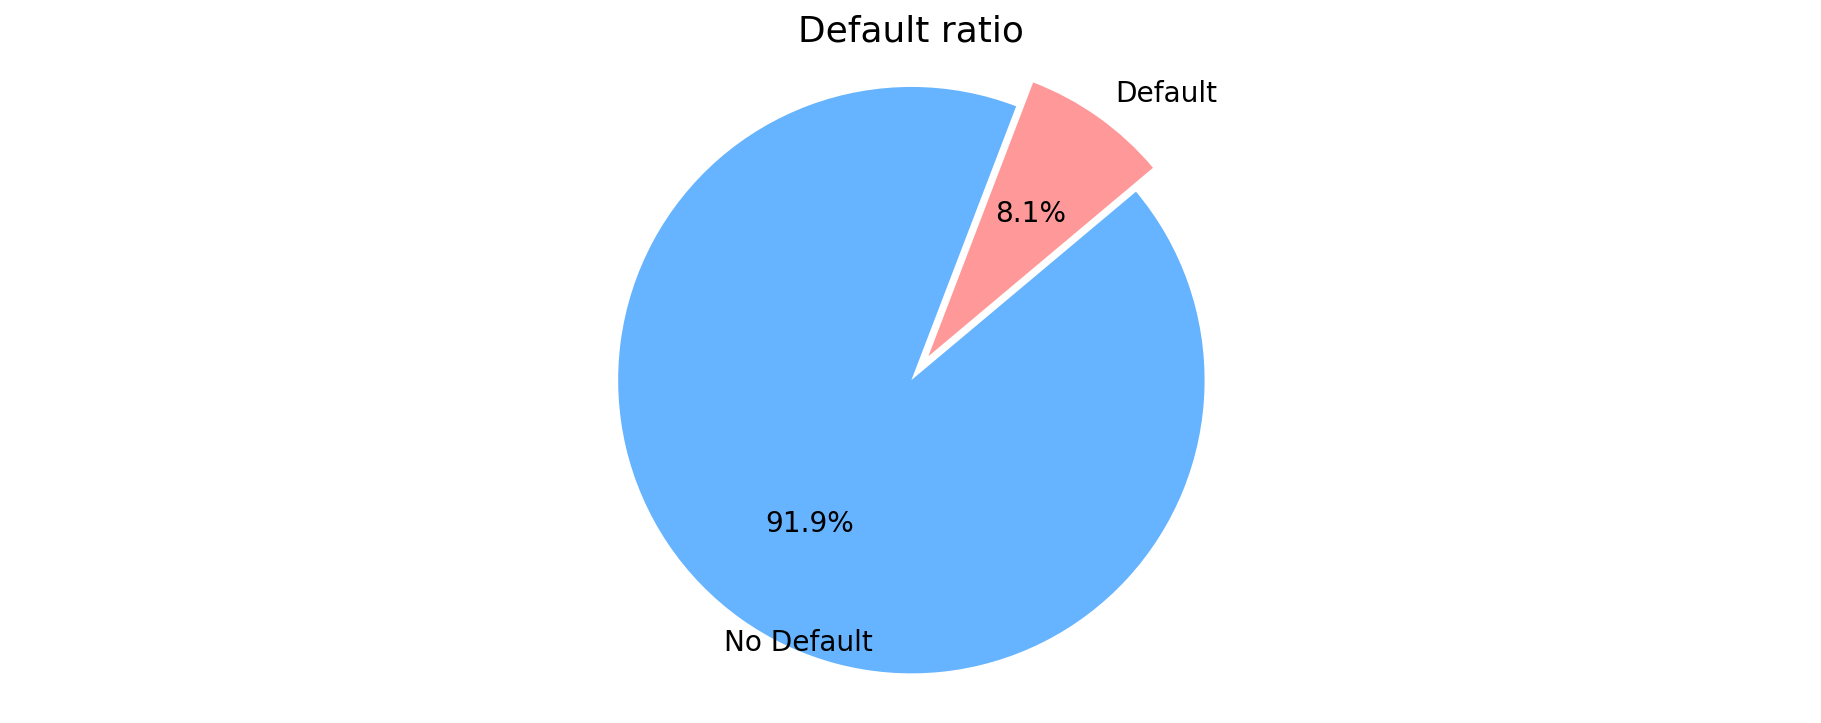

In [154]:
prob = learning_Y.sum()
n_prob = len(learning_Y)
n_prob = n_prob - prob

labels = 'Default', 'No Default'
sizes = [prob, n_prob]
colors = ['#ff9999','#66b3ff']
explodes = (0, 0.1)

# Plot
plt.figure(figsize = (16,6))
patches, texts, autotexts = plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=40,
       center=(1000,10), colors = colors, explode=explodes)

for t, at in zip(texts, autotexts):
    t.set_fontsize(14)
    at.set_fontsize(14)
plt.axis('equal')
plt.title('Default ratio', fontsize=(18))
plt.show()

Very unbalanced

# Checking for missing data

## Principal

In [286]:
total = principal.isnull().sum().sort_values(ascending = False)
percent = (principal.isnull().sum()/principal.isnull().count()*100).sort_values(ascending = False)
missing  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing[missing.Percent>=1]

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_MODE,214865,69.872297
COMMONAREA_AVG,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953


## Bureau

In [301]:
total = bureau.isnull().sum().sort_values(ascending = False)
percent = (bureau.isnull().sum()/bureau.isnull().count()*100).sort_values(ascending = False)
missing  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing

,Total,Percent
STATUS,0,0.0
MONTHS_BALANCE,0,0.0
SK_ID_BUREAU,0,0.0


## Cash

In [306]:
total = cash.isnull().sum().sort_values(ascending = False)
percent = (cash.isnull().sum()/cash.isnull().count()*100).sort_values(ascending = False)
missing  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing

,Total,Percent
CNT_INSTALMENT_FUTURE,26087,0.260835
CNT_INSTALMENT,26071,0.260675
SK_DPD_DEF,0,0.000000
SK_DPD,0,0.000000
NAME_CONTRACT_STATUS,0,0.000000
MONTHS_BALANCE,0,0.000000
SK_ID_CURR,0,0.000000
SK_ID_PREV,0,0.000000


## Credit card

In [307]:
total = credit_card.isnull().sum().sort_values(ascending = False)
percent = (credit_card.isnull().sum()/credit_card.isnull().count()*100).sort_values(ascending = False)
missing  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing[missing.Percent>=1]

,Total,Percent
AMT_PAYMENT_CURRENT,767988,19.998063
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872
CNT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_DRAWINGS_OTHER_CURRENT,749816,19.524872
CNT_DRAWINGS_ATM_CURRENT,749816,19.524872
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872
AMT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_INSTALMENT_MATURE_CUM,305236,7.948208
AMT_INST_MIN_REGULARITY,305236,7.948208


## Previous applications

In [308]:
total = previous_app.isnull().sum().sort_values(ascending = False)
percent = (previous_app.isnull().sum()/previous_app.isnull().count()*100).sort_values(ascending = False)
missing  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing[missing.Percent>=1]

,Total,Percent
RATE_INTEREST_PRIVILEGED,1664263,99.643698
RATE_INTEREST_PRIMARY,1664263,99.643698
RATE_DOWN_PAYMENT,895844,53.636480
AMT_DOWN_PAYMENT,895844,53.636480
NAME_TYPE_SUITE,820405,49.119754
DAYS_TERMINATION,673065,40.298129
NFLAG_INSURED_ON_APPROVAL,673065,40.298129
DAYS_FIRST_DRAWING,673065,40.298129
DAYS_FIRST_DUE,673065,40.298129
DAYS_LAST_DUE_1ST_VERSION,673065,40.298129


## Payments

In [309]:
total = previous_app.isnull().sum().sort_values(ascending = False)
percent = (previous_app.isnull().sum()/previous_app.isnull().count()*100).sort_values(ascending = False)
missing  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing[missing.Percent>=1]

,Total,Percent
RATE_INTEREST_PRIVILEGED,1664263,99.643698
RATE_INTEREST_PRIMARY,1664263,99.643698
RATE_DOWN_PAYMENT,895844,53.636480
AMT_DOWN_PAYMENT,895844,53.636480
NAME_TYPE_SUITE,820405,49.119754
DAYS_TERMINATION,673065,40.298129
NFLAG_INSURED_ON_APPROVAL,673065,40.298129
DAYS_FIRST_DRAWING,673065,40.298129
DAYS_FIRST_DUE,673065,40.298129
DAYS_LAST_DUE_1ST_VERSION,673065,40.298129


We see lots of missing data. Since we have so much different information, it will be a good strategy to drop all the features that have more than 25% of missing data

# What's the porportion of male/female in data?

(-1.2922379107385071,
 1.363042094334471,
 -1.3624943856745182,
 1.2926559820824939)

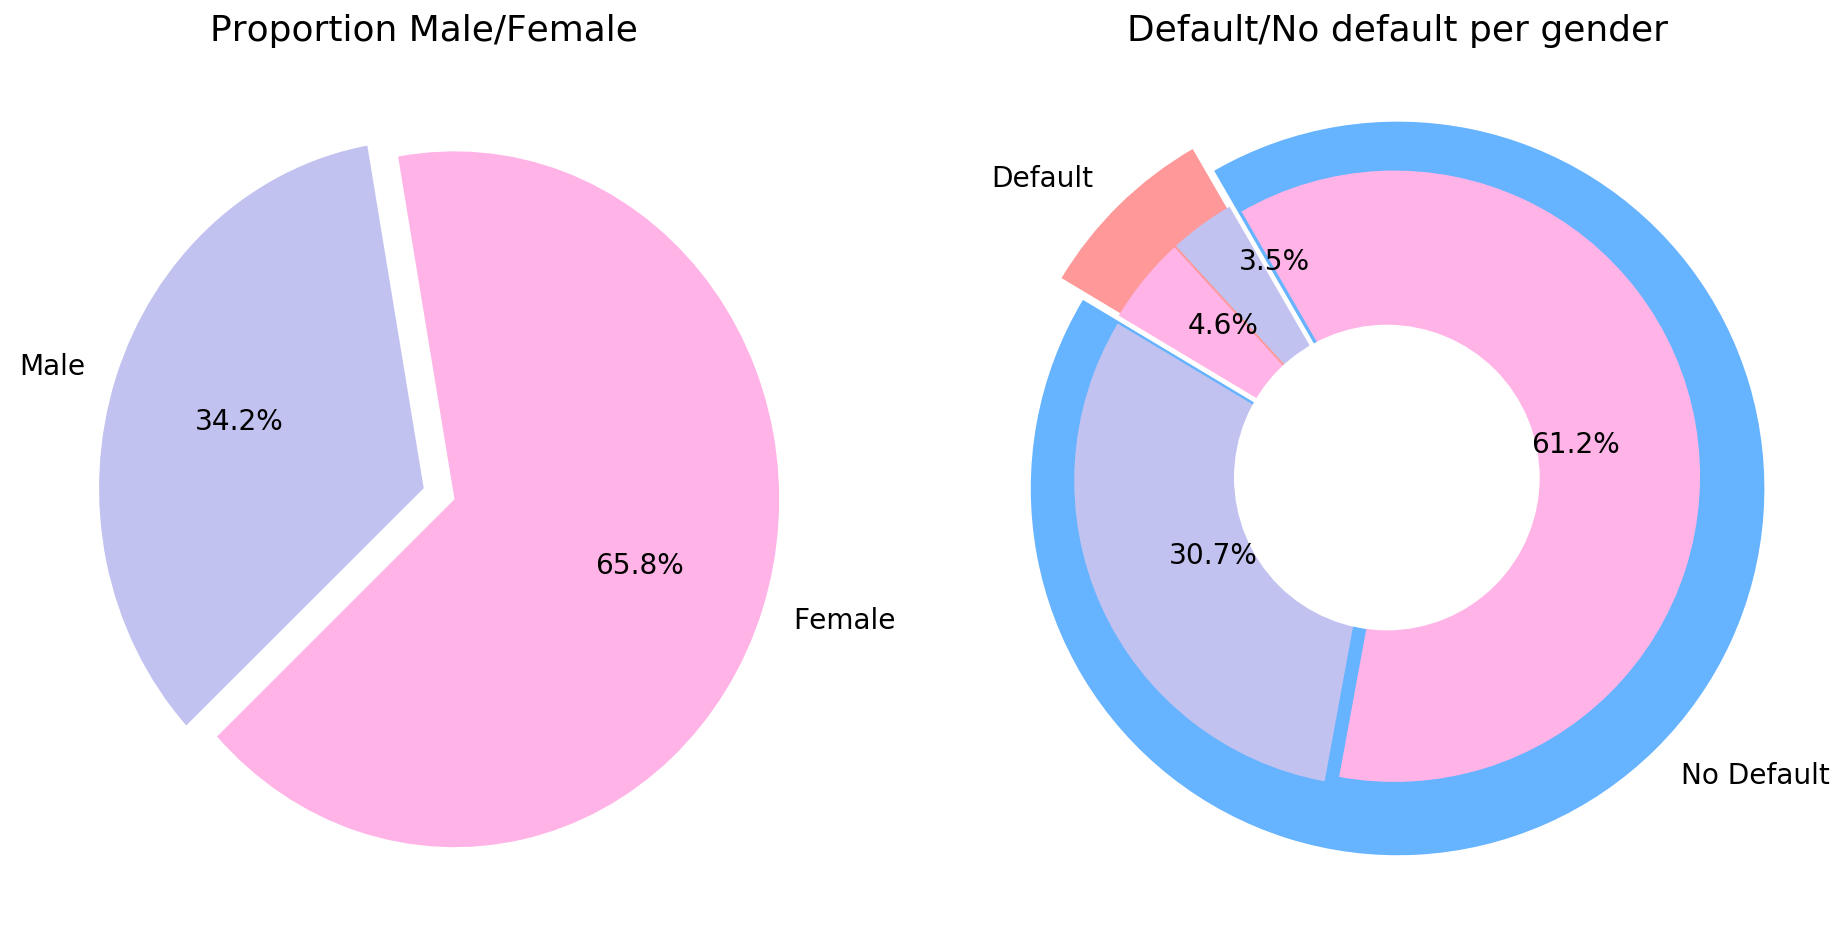

In [212]:
M = len(principal.loc[:,'CODE_GENDER'][principal.CODE_GENDER == 'M'])
F = len(principal.CODE_GENDER)
F = F - M

colors_gender = ['#c2c2f0','#ffb3e6']
explodes = (0, 0.1)

fig, axs = plt.subplots(1,2, figsize=(16,8))

patches, texts, autotexts = axs[0].pie([M, F], labels= ['Male', 'Female'], autopct='%1.1f%%', startangle=100,
       colors = colors_gender, explode=explodes)
for t, at in zip(texts, autotexts):
    t.set_fontsize(14)
    at.set_fontsize(14)

axs[0].set_title('Proportion Male/Female', fontsize=(18))

temp1 = principal[principal.TARGET == 1]
M1 = len(temp.loc[:'CODE_GENDER'][temp.CODE_GENDER == 'M'])
M2 = M - M1
F1 = len(temp.CODE_GENDER) - M1
F2 = F - F1

labels_gender = ['M', 'F', 'M', 'F']
colors_gender = ['#c2c2f0','#ffb3e6', '#c2c2f0','#ffb3e6']
patches, texts = axs[1].pie(sizes, labels=labels, colors=colors, startangle=120,frame=True, 
                                       explode=(0.05, 0.05),radius=1.2, center=(0,0))

patches, texts_gender, autotexts_gender = axs[1].pie([M1, F1, M2, F2], autopct='%1.1f%%', startangle=120,
       colors = colors_gender, explode=(0.025,0.025,0.025,0.025),radius=1, center=(0,0) )

#Draw circle
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

for t in texts:
    t.set_fontsize(14)

for t in autotexts_gender:
    t.set_fontsize(14)

x,y = autotexts_gender[0].get_position()
autotexts_gender[0].set_position((x,y+0.2))

x,y = autotexts_gender[1].get_position()
autotexts_gender[1].set_position((x-0.05,y+0.1))

axs[1].set_title('Default/No default per gender', fontsize = (18))
plt.axis('equal')

# What's is the proportion of home owner's and car owner's?

(-1.120726725845517,
 1.1956208891557571,
 -1.1200568218949758,
 1.1849772201082727)

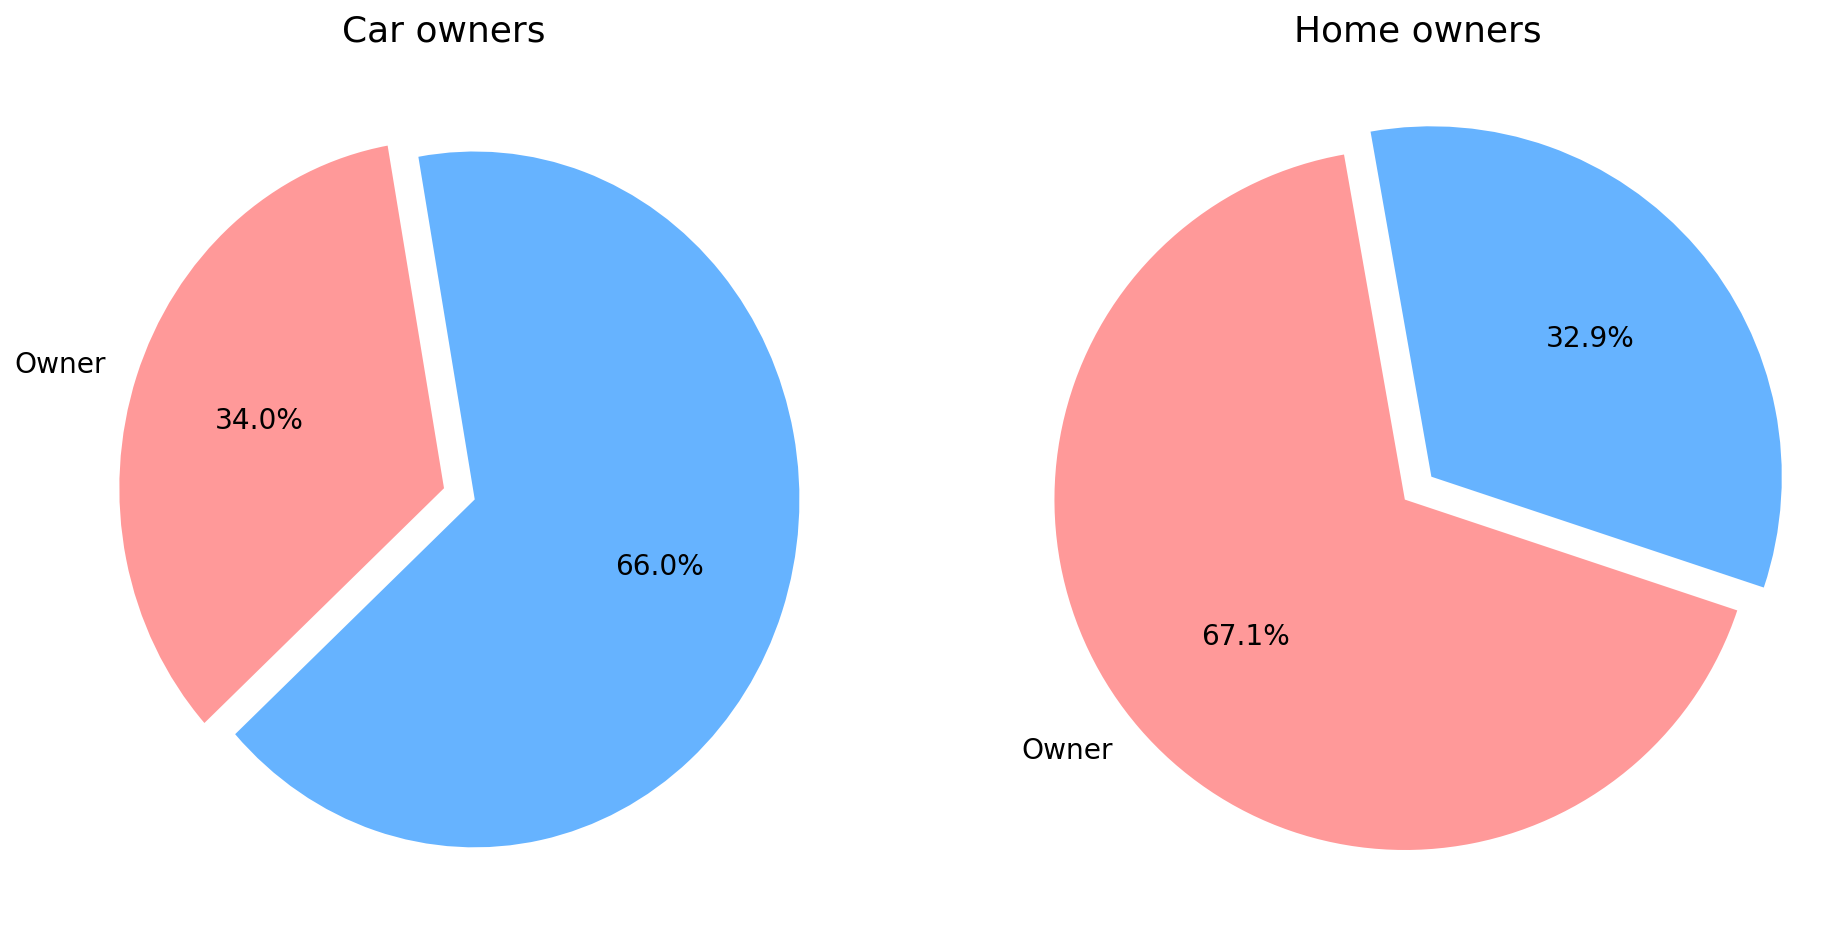

In [214]:
# Assessing data
car_y = len(principal.loc[:,'FLAG_OWN_CAR'][principal.FLAG_OWN_CAR == 'Y'])
car_n = len(principal.loc[:, 'FLAG_OWN_CAR']) - car_y

home_y = len(principal.loc[:,'FLAG_OWN_REALTY'][principal.FLAG_OWN_REALTY == 'Y'])
home_n = len(principal.loc[:,'FLAG_OWN_REALTY']) - car_n

### Ploting ###
fig, axs = plt.subplots(1,2, figsize=(16,8))

## First plot 
patches, texts, autotexts = axs[0].pie([car_y, car_n], labels= ['Owner', ''], autopct='%1.1f%%', startangle=100,
       colors = colors, explode=explodes)

# Adjusting the plot
for t in texts:
    t.set_fontsize(14)
for t in autotexts:
    t.set_fontsize(14)
    
axs[0].set_title('Car owners', fontsize=(18))

## Second plot
patches, texts, autotexts = axs[1].pie([home_y, home_n], labels= ['Owner', ''], autopct='%1.1f%%', startangle=100,
       colors = colors, explode=explodes)

# Adjusting the plot
for t in texts:
    t.set_fontsize(14)
for t in autotexts:
    t.set_fontsize(14)
    
axs[1].set_title('Home owners', fontsize=(18))


# What's the distribution of income among clients?

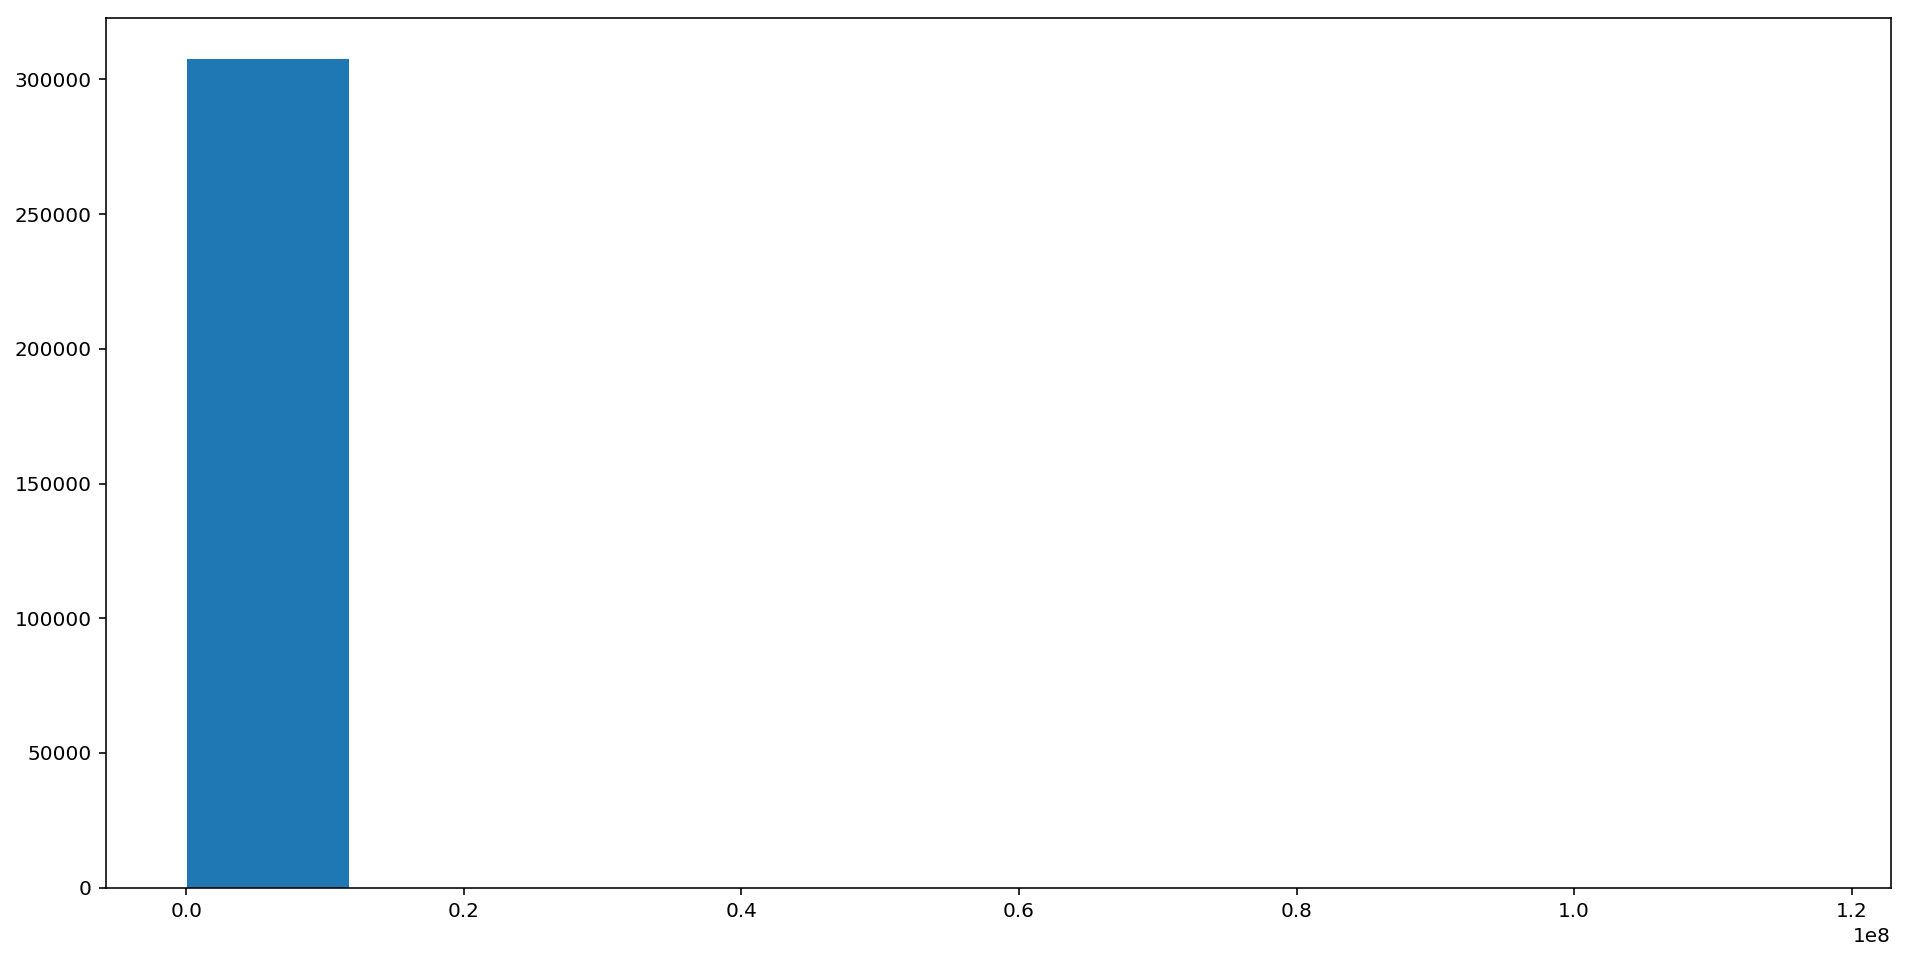

In [263]:
plt.figure(figsize=(16,8))
plt.hist(principal.AMT_INCOME_TOTAL);
plt.show()

That doesn't say much, probably we have a lot of outliers. Let's try to look trough those

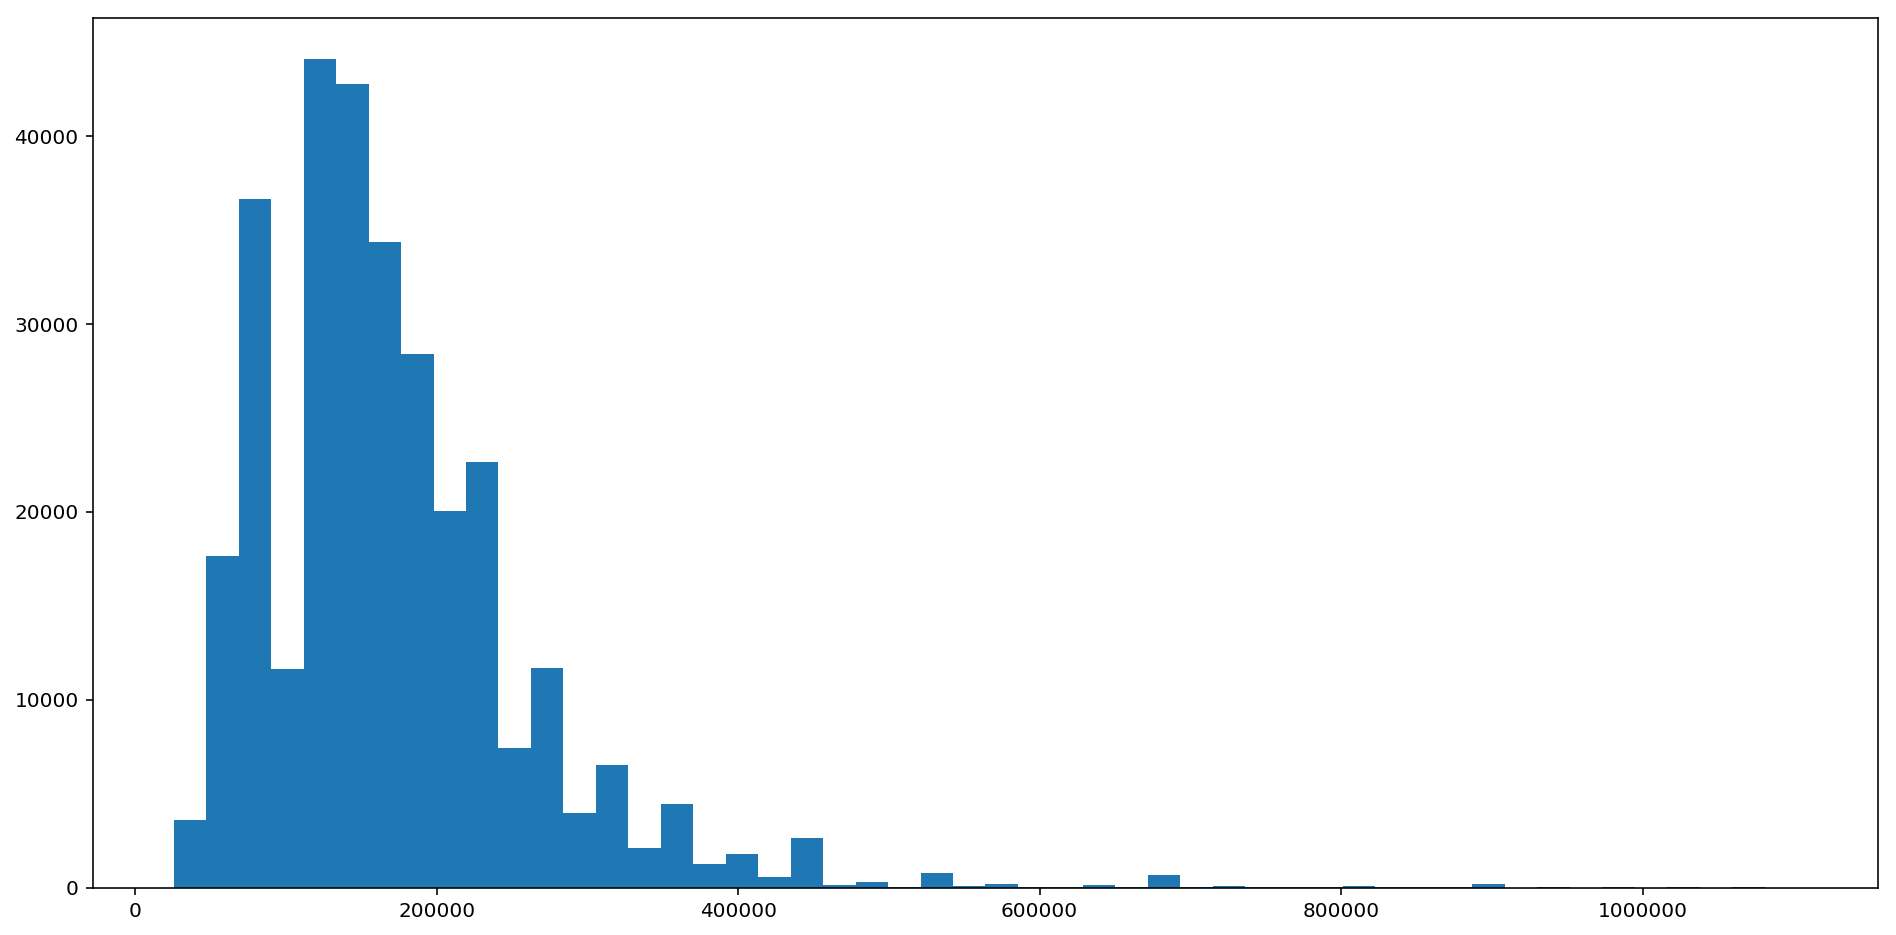

In [266]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

filtered_income = reject_outliers(principal.AMT_INCOME_TOTAL.values, m=4)

plt.figure(figsize=(16,8))
plt.hist(filtered_income, bins=50);
plt.show()

In [276]:
print('Mean income: {0:,.2f}'.format(principal.AMT_INCOME_TOTAL.values.mean()))
print('Standard deviation of income: {0:,.2f}'.format(principal.AMT_INCOME_TOTAL.values.std()))
print('Maximum value in relative to std deviation: {0:,.2f}'.format(max(principal.AMT_INCOME_TOTAL.values)/principal.AMT_INCOME_TOTAL.values.std()))
print('Minimum value in relative to std deviation: {0:,.2f}'.format(min(principal.AMT_INCOME_TOTAL.values)/principal.AMT_INCOME_TOTAL.values.std()))

Mean income: 168,797.92
Standard deviation of income: 237,122.76
Maximum value in relative to std deviation: 493.42
Minimum value in relative to std deviation: 0.11


As we can see there are a lot of outliers in the income data

# How much credit are people getting?

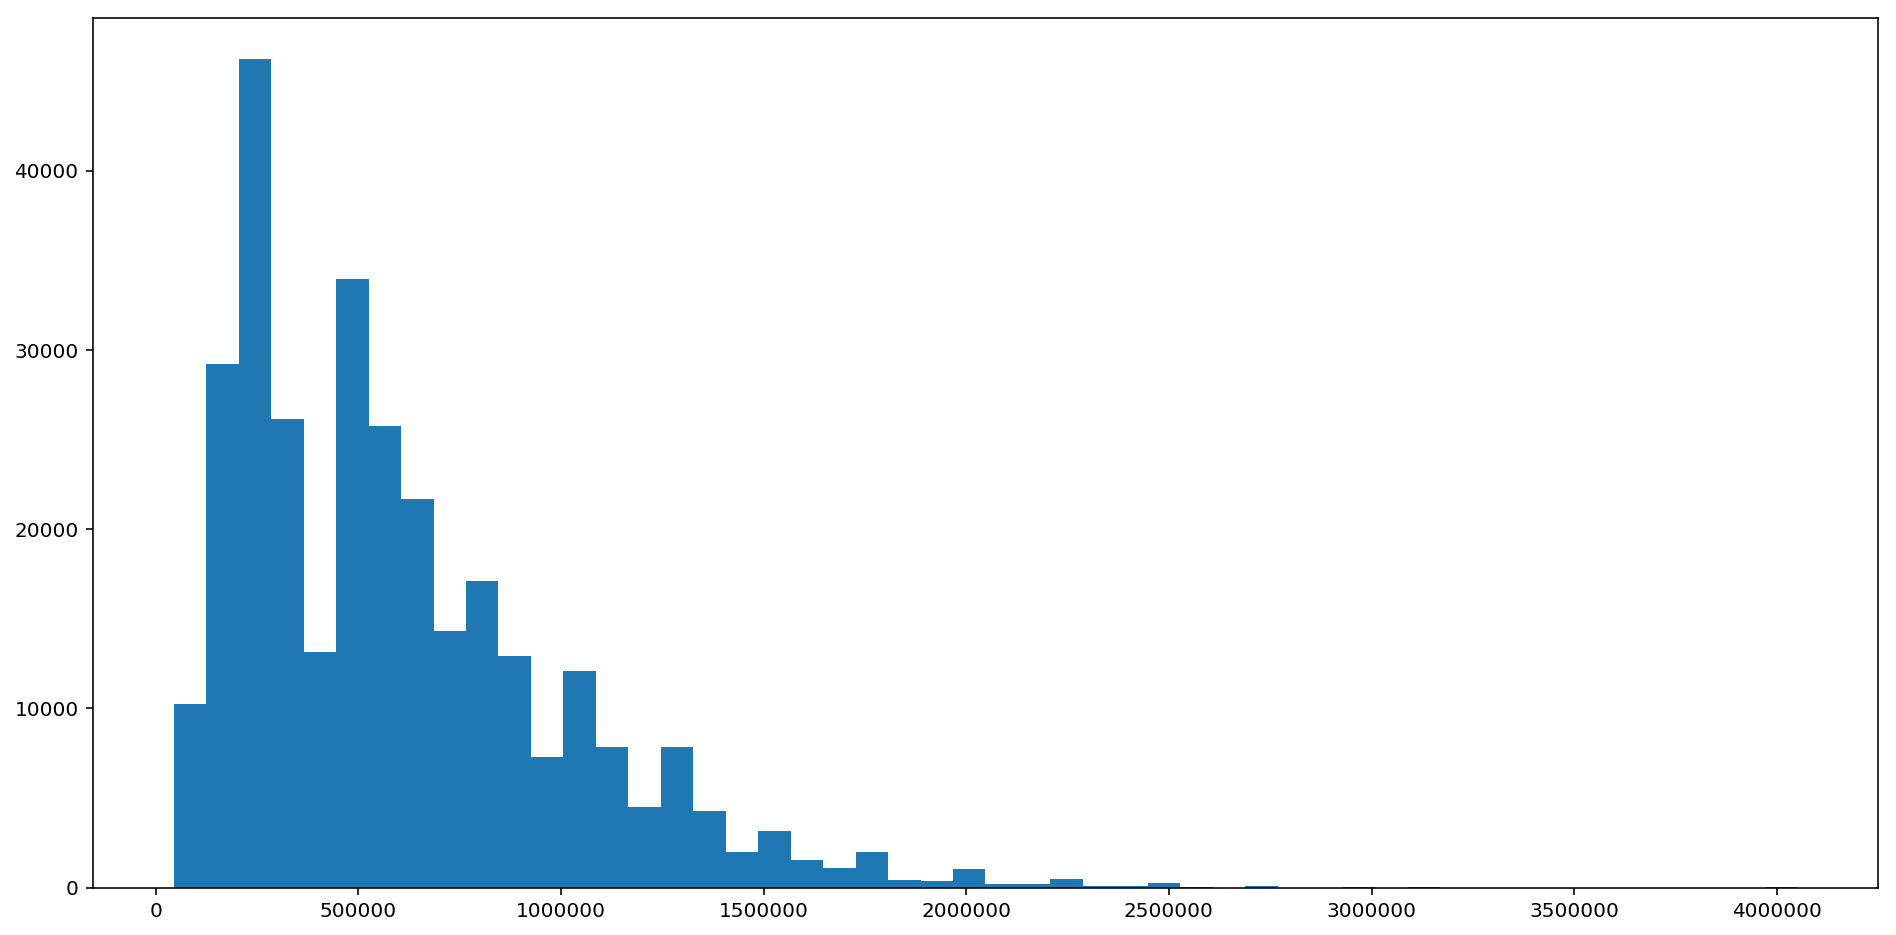

In [278]:
plt.figure(figsize=(16,8))
plt.hist(principal.AMT_CREDIT, bins=50);
plt.show()

In [280]:
print('Mean credit value: {0:,.2f}'.format(principal.AMT_CREDIT.values.mean()))
print('Standard deviation of credit value: {0:,.2f}'.format(principal.AMT_CREDIT.values.std()))
print('Maximum value in relative to std deviation: {0:,.2f}'.format(max(principal.AMT_CREDIT.values)/principal.AMT_CREDIT.values.std()))
print('Minimum value in relative to std deviation: {0:,.2f}'.format(min(principal.AMT_CREDIT.values)/principal.AMT_CREDIT.values.std()))

Mean credit value: 599,026.00
Standard deviation of credit value: 402,490.12
Maximum value in relative to std deviation: 10.06
Minimum value in relative to std deviation: 0.11


# How all this relates to loan annuity and the price of the good that is being bought with the credit?

I would like to build 2 metrics that may express this relation: 
 1. Loan to value ratio (LTVR)
 1. Income commitment

But in order to do so I need to deal with some missing data

In [311]:
dit = {}
columns = ['AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL']

for col in columns:
    total = principal.loc[:, col].isnull().sum()
    percent = (principal.loc[:, col].isnull().sum()/principal.loc[:, col].isnull().count()*100)
    dit[col] = [total, percent]

dit

{'AMT_ANNUITY': [12, 0.003902299429939092],
 'AMT_CREDIT': [0, 0.0],
 'AMT_GOODS_PRICE': [278, 0.09040327012692229],
 'AMT_INCOME_TOTAL': [0, 0.0]}

Let's try to complete the amounts of annuity payments and the prices of goods that are missing with the avarege of the previous loans from the same client

In [342]:
# Selecting the missing data in the previous loans dataframe

select = list(principal['SK_ID_CURR'][list(principal['AMT_ANNUITY'].isnull())])
df_temp = previous_app.loc[previous_app['SK_ID_CURR'].isin(select)]
df_select1 = df_temp.loc[:,['AMT_ANNUITY', 'SK_ID_CURR']].copy()

select = list(principal['SK_ID_CURR'][list(principal['AMT_GOODS_PRICE'].isnull())])
df_temp = previous_app.loc[previous_app['SK_ID_CURR'].isin(select)]
df_select2 = df_temp.loc[:,['AMT_GOODS_PRICE', 'SK_ID_CURR']]

del df_temp

In [352]:
# Replacing missing values for AMT_ANNUITY
df_select1 = df_select1.groupby('SK_ID_CURR', as_index=False).mean()
principal.loc[list(principal['AMT_ANNUITY'].isnull()),'AMT_ANNUITY'] = list(df_select1['AMT_ANNUITY'])

In [369]:
# Replacing missing values for AMT_GOODS_PRICE
df_select2 = df_select2.groupby('SK_ID_CURR', as_index=False).mean()
principal.loc[principal['SK_ID_CURR'].isin(list(df_select2.SK_ID_CURR)),
              'AMT_GOODS_PRICE'] = list(df_select2['AMT_GOODS_PRICE'])

In [372]:
# Checking what I achieve
del df_select1, df_select2
gc.collect();

dit = {}
columns = ['AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL']

for col in columns:
    total = principal.loc[:, col].isnull().sum()
    percent = (principal.loc[:, col].isnull().sum()/principal.loc[:, col].isnull().count()*100)
    dit[col] = [total, percent]

dit

{'AMT_ANNUITY': [0, 0.0],
 'AMT_CREDIT': [0, 0.0],
 'AMT_GOODS_PRICE': [11, 0.003577107810777501],
 'AMT_INCOME_TOTAL': [0, 0.0]}

Most of the missing were dealt with. The remaining data will be deleted